In [15]:
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from random import random
from math import exp
from statistics import mean
from sklearn.linear_model import SGDClassifier

In [26]:
def loadData():
        data = load_breast_cancer()
        inputs = data['data']
        outputs = data['target']
        outputNames = data['target_names']
        featureNames = list(data['feature_names'])
        feature1 = [feat[featureNames.index('mean radius')] for feat in inputs]
        feature2 = [feat[featureNames.index('mean texture')] for feat in inputs]
        inputs = [[feat[featureNames.index('mean radius')], feat[featureNames.index('mean texture')]] for feat in inputs]
        return inputs, outputs, outputNames, feature1, feature2, featureNames[:2]

In [27]:
def plotData(inputs, outputs, outputNames, featureNames, title=None):
    labels = set(outputs)
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noData) if outputs[i] == crtLabel]
        y = [inputs[i][1] for i in range(noData) if outputs[i] == crtLabel]
        plt.scatter(x, y, label=outputNames[crtLabel])
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.title(title)
    plt.show()


def plotHistogram(feature, variableName):
    plt.hist(feature, 10)
    plt.title('Histogram of ' + variableName)
    plt.show()


def plotPredictions(inputs, realOutputs, computedOutputs, labelNames, featureNames, title=None):
    labels = list(set(realOutputs))
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel]
        y = [inputs[i][1] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel]
        plt.scatter(x, y, label=labelNames[crtLabel] + ' (correct)')
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel]
        y = [inputs[i][1] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel]
        plt.scatter(x, y, label=labelNames[crtLabel] + ' (incorrect)')
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.title(title)
    plt.legend()
    plt.show()

In [28]:
class MyLogisticRegression:
    def __init__(self, threshold):
        self.intercept_ = 0.0
        self.coef_ = []
        self.loss = []
        self.threshold = threshold

    def fit(self, x, y, learningRate=0.001, noEpochs=1000):
        self.coef_ = [random() for _ in range(len(x[0]) + 1)] # initializam coeficienti random pt fiecare feature
        
        for epoch in range(noEpochs):
            epochLoss = []
            for i in range(len(x)):
                yComputed = sigmoid(self.eval(x[i], self.coef_))
                crtError = yComputed - y[i]
                epochLoss.append(crtError)
                for j in range(0, len(x[0])):
                    self.coef_[j + 1] = self.coef_[j + 1] - learningRate * crtError * x[i][j]
                self.coef_[0] = self.coef_[0] - learningRate * crtError * 1
            self.loss.append(mean(epochLoss))
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]

    def eval(self, xi, coefficient):
        yi = coefficient[0]
        for j in range(len(xi)):
            yi += coefficient[j + 1] * xi[j]
        return yi

    def predictOneSample(self, sampleFeatures):
        threshold = self.threshold
        coefficients = [self.intercept_] + [c for c in self.coef_]
        computedValue = self.eval(sampleFeatures, coefficients)
        computed01Value = sigmoid(computedValue)
        computedLabel = 0 if computed01Value < threshold else 1
        return computedLabel

    def predict(self, inTest):
        computedLabels = [self.predictOneSample(sample) for sample in inTest]
        return computedLabels

In [29]:
def sigmoid(x):
    return 1 / (1 + exp(-x))
    
def mse(computed, real):
    error = 0.0
    for y1, y2 in zip(computed, real):
        error += (y1 - y2) ** 2
    error /= len(real)
    return error

In [30]:
# split data into training and testing sets
def splitData(inputs, outputs):
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
    testSample = [i for i in indexes if i not in trainSample]
    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]
    return trainInputs, trainOutputs, testInputs, testOutputs


def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        #encode each sample into a list
        trainData = [[d] for d in trainData]
        testData = [[d] for d in testData]
        
        scaler.fit(trainData) # fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data

        #decode from list to raw values
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(trainData) # fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
    return normalisedTrainData, normalisedTestData

In [31]:
def learnModelTool(trainInputs, trainOutputs, testInputs, testOutputs):
    classifier = linear_model.LogisticRegression()
    classifier.fit(trainInputs, trainOutputs)
    
    w0, w1, w2 = classifier.intercept_[0], classifier.coef_[0][0], classifier.coef_[0][1]
    print('classification model by tool: y =', w0, '+', w1, '* x1 +', w2, '* x2')
    
    computedOutputs = classifier.predict(testInputs)
    print("Accuracy score:", classifier.score(testInputs, testOutputs))
    
    return computedOutputs


def learnModel(trainInputs, trainOutputs, testInputs, testOutputs, dim_leziune):
    classifier = MyLogisticRegression(0.5)
    classifier.fit(trainInputs, trainOutputs)

    plt.plot(classifier.loss, [index for index in range(len(classifier.loss))])
    plt.show()
    
    w0, w1, w2 = classifier.intercept_, classifier.coef_[0], classifier.coef_[1]
    print('classification model: y =', w0, '+', w1, '* x1 +', w2, '* x')
    
    computedOutputs = [1 if sigmoid(w0 + w1 * el[0] + w2 * el[1]) > 0.5 else 0 for el in testInputs]
    noData = len(testInputs)
    accuracy = 0.0
    for i in range(noData):
        if testOutputs[i] == computedOutputs[i]:
            accuracy += 1
    print("Accuracy score:", accuracy / noData)

    # predictie leziune
    leziune = classifier.predict(dim_leziune)
    return computedOutputs, leziune

In [32]:
def calculatePerformance(computedOutputs, testOutputs, method):
    error = 0.0
    for t1, t2 in zip(computedOutputs, testOutputs):
        if t1 != t2:
            error += 1
    error = error / len(testOutputs)
    print('classification error ', method, ':', error)

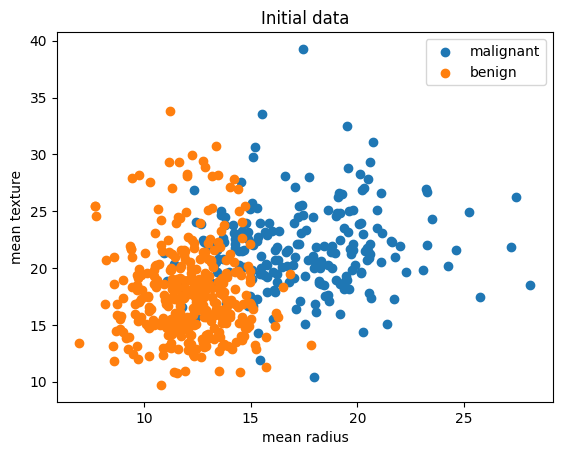

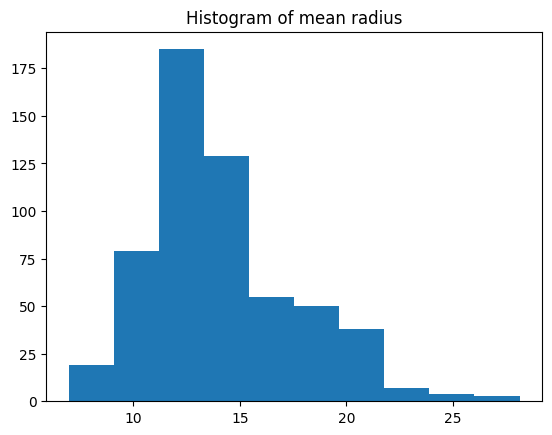

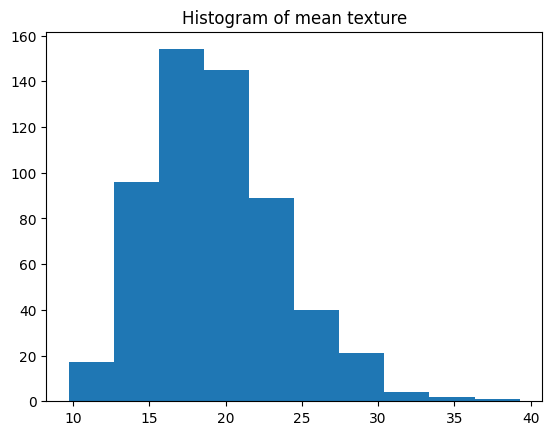

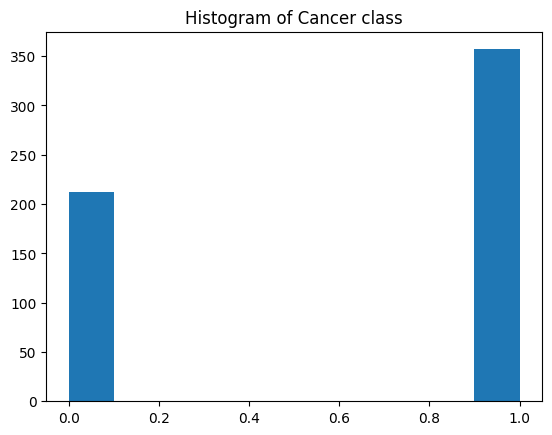

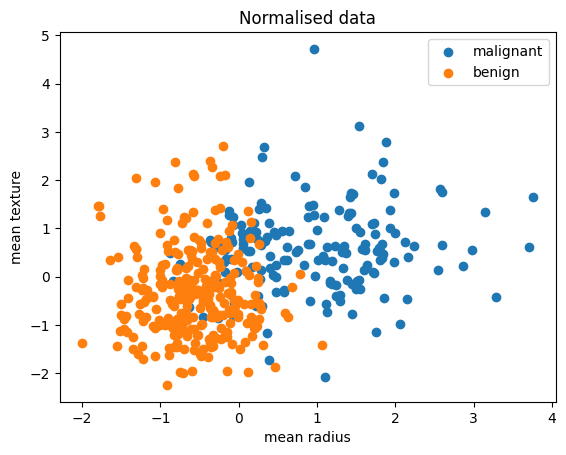

classification model by tool: y = 0.7143034858434365 + -3.2098180149892612 * x1 + -0.8885375103356505 * x2
Accuracy score: 0.8947368421052632


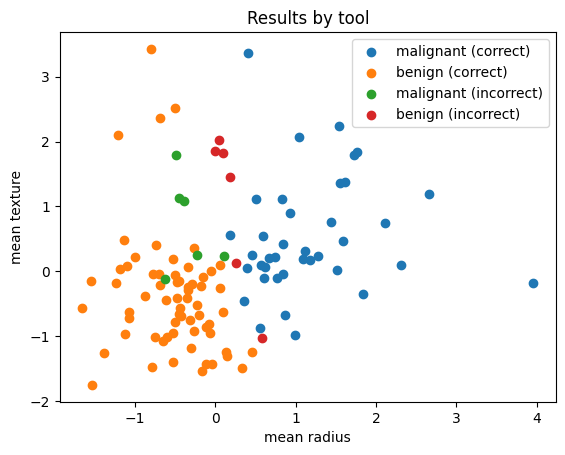

classification error  by tool : 0.10526315789473684


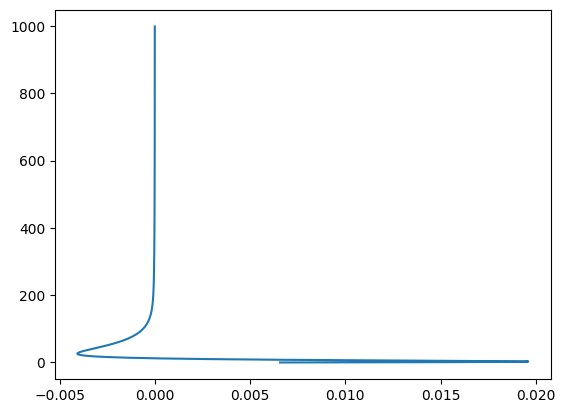

classification model: y = 0.7185162484744075 + -3.6629272491382565 * x1 + -0.9593311133310917 * x
Accuracy score: 0.8947368421052632


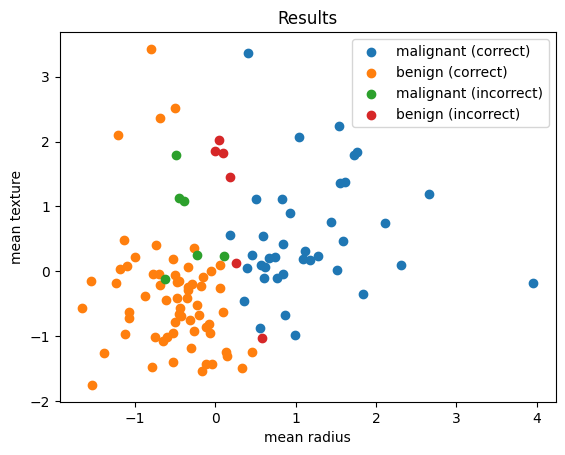

classification error   : 0.10526315789473684

 Predictie leziune:  benign


In [33]:
# load data
inputs, outputs, outputNames, feature1, feature2, featureNames = loadData()
# plot initial data
plotData(inputs, outputs, outputNames, featureNames, "Initial data")

# plot histograms for features and output
plotHistogram(feature1, featureNames[0])
plotHistogram(feature2, featureNames[1])
plotHistogram(outputs, 'Cancer class')

# split data into training and testing sets
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)
# normalize the input data
trainInputs, testInputs = normalisation(trainInputs, testInputs)
# plot normalized data
plotData(trainInputs, trainOutputs, outputNames, featureNames, "Normalised data")

# learn the model by tool
computedTestOutputs = learnModelTool(trainInputs, trainOutputs, testInputs, testOutputs)
# plot predictions made by the tool
plotPredictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames, "Results by tool")
# calculate performance metrics for the tool's predictions
calculatePerformance(computedTestOutputs, testOutputs, "by tool")

# prediction new input data
dimensiuni = [[10, 18]]
dim, dim_leziune = normalisation(dimensiuni, dimensiuni)
# learn the model
computedTestOutputs, leziune = learnModel(trainInputs, trainOutputs, testInputs, testOutputs, dim_leziune)
# plot predictions
plotPredictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames, "Results")
# calculate performance metrics
calculatePerformance(computedTestOutputs, testOutputs, "")

# predictie leziune noua
print("\n Predictie leziune: ", outputNames[leziune[0]])

In [34]:
def otherLossFunction(train_inputs, train_outputs, test_inputs, test_outputs):
    classifier = SGDClassifier(loss='log_loss')   #stohastic gradient descent folosing loss
    classifier.fit(train_inputs, train_outputs)
    print('Accuracy score (log loss by tool):', classifier.score(test_inputs, test_outputs))
    classifier = SGDClassifier(loss='hinge')     #folosind hinge
    classifier.fit(train_inputs, train_outputs)
    print('Accuracy score (hinge loss by tool):', classifier.score(test_inputs, test_outputs))
    classifier = SGDClassifier(loss='squared_hinge') #folosind squared_hindge
    classifier.fit(train_inputs, train_outputs)
    print('Accuracy score (squared hinge loss by tool):', classifier.score(test_inputs, test_outputs))

Other loss functions:
Accuracy score (log loss by tool): 0.8859649122807017
Accuracy score (hinge loss by tool): 0.868421052631579
Accuracy score (squared hinge loss by tool): 0.8771929824561403
Bigger threshold
Accuracy score: 0.8947368421052632


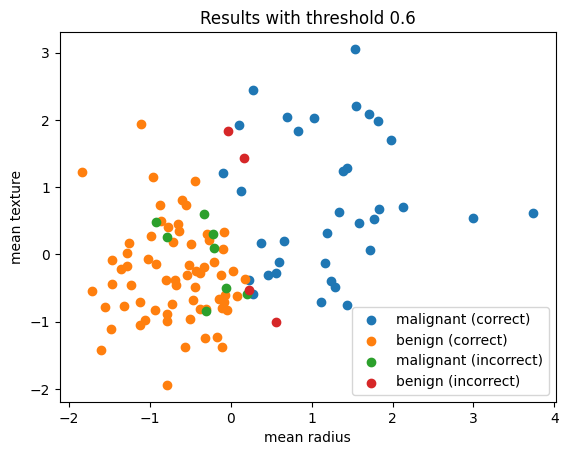

Less threshold
Accuracy score: 0.8859649122807017


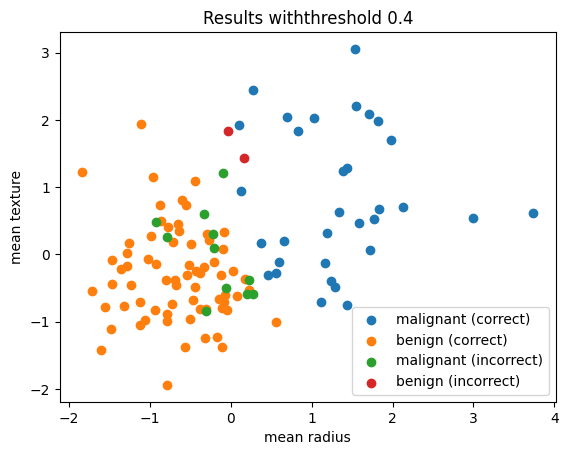

In [35]:
print("Other loss functions:")
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)
trainInputs, testInputs = normalisation(trainInputs, testInputs)
otherLossFunction(trainInputs, trainOutputs, testInputs, testOutputs)

print("Bigger threshold")
classifier = MyLogisticRegression(0.6)
classifier.fit(trainInputs, trainOutputs)

computedTestOutputs=[1 if sigmoid(classifier.intercept_ + classifier.coef_[0] * el[0] + classifier.coef_[1] * el[1]) > 0.6 else 0 for el in testInputs]
    
noData = len(testInputs)
accuracy = 0.0
for i in range(noData):
    if testOutputs[i] == computedTestOutputs[i]:
        accuracy += 1
print("Accuracy score:", accuracy / noData)
plotPredictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames, "Results with threshold 0.6")

print("Less threshold")
classifier = MyLogisticRegression(0.4)
classifier.fit(trainInputs, trainOutputs)

computedTestOutputs=[1 if sigmoid(classifier.intercept_ + classifier.coef_[0] * el[0] + classifier.coef_[1] * el[1]) > 0.4 else 0 for el in testInputs]
    
noData = len(testInputs)
accuracy = 0.0
for i in range(noData):
    if testOutputs[i] == computedTestOutputs[i]:
        accuracy += 1
print("Accuracy score:", accuracy / noData)

plotPredictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames, "Results withthreshold 0.4")